In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
np.random.seed(44)

In [2]:
# generate fake data
n_fleets = 30
n_vehicles = np.random.randint(1, 100, size = n_fleets)
true_risk_average = 3/4
true_precision = 4
fleet_true_risk = np.random.beta(true_risk_average*true_precision, (1 - true_risk_average)*true_precision, size = n_fleets)

In [3]:
fleets_data = pd.DataFrame({
    "fleet_id":range(n_fleets),
    "n_vehicles_in_fleet":n_vehicles,
    "fleet_true_risk":fleet_true_risk
})

In [4]:
fleets_data.head()

,fleet_id,n_vehicles_in_fleet,fleet_true_risk
0,0,21,0.519144
1,1,36,0.868704
2,2,46,0.886922
3,3,60,0.815206
4,4,4,0.813580


In [5]:
fleets_data["fleet_true_risk"].mean()

0.8196017041014166

In [6]:
vehicles_data = []
for i in range(n_fleets):
    fleet_true_risk = fleets_data[fleets_data.fleet_id == i]["fleet_true_risk"].iloc[0]
    n_vehicles_in_fleet = fleets_data[fleets_data.fleet_id == i]["n_vehicles_in_fleet"].iloc[0]
    k = 10
    vehicle_scores = np.random.beta(fleet_true_risk*k, (1 - fleet_true_risk)*k, size =n_vehicles_in_fleet)
    vehicles_data.append(
        pd.DataFrame({
            "fleet_id":[i for _ in range(n_vehicles_in_fleet)],
            "fleet_vehicle_id":[f"{i}{j}" for j in range(n_vehicles_in_fleet)],
            "vehicle_score": vehicle_scores
        })
    )

In [7]:
vehicles_data = pd.concat(vehicles_data)

In [8]:
vehicles_data.head()

,fleet_id,fleet_vehicle_id,vehicle_score
0,0,00,0.525122
1,0,01,0.553362
2,0,02,0.535145
3,0,03,0.814699
4,0,04,0.445337


In [32]:
inference = vehicles_data.groupby("fleet_id")["vehicle_score"].mean().reset_index().merge(fleets_data).rename({"vehicle_score":"score_mean"})
inference

,fleet_id,vehicle_score,n_vehicles_in_fleet,fleet_true_risk
0,0,0.517449,21,0.519144
1,1,0.856283,36,0.868704
2,2,0.890510,46,0.886922
3,3,0.806005,60,0.815206
4,4,0.744982,4,0.813580
5,5,0.758960,97,0.774845
6,6,0.985451,85,0.982724
7,7,0.960592,4,0.960276
8,8,0.575976,24,0.577922
9,9,0.556727,56,0.579910


<Axes: >

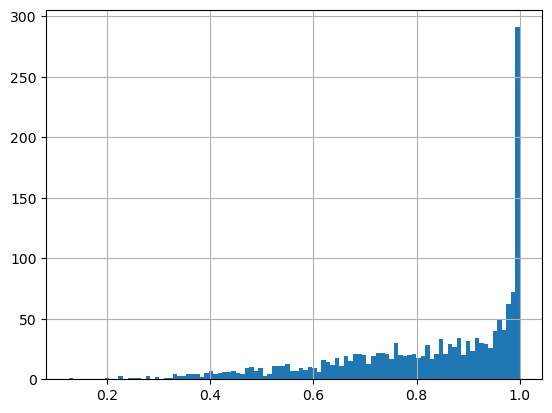

In [10]:
vehicles_data.vehicle_score.hist(bins = 100)

In [17]:
with pm.Model() as model:
    omega0 = pm.Beta("omega0", 1, 1)
    kappa0_minus_two = pm.Gamma("kappa0_minus_two", 2, 2)
    kappa0 = pm.Deterministic("kappa0", kappa0_minus_two + 2)
    trace = pm.sample()

/tmp/ipykernel_8125/1694353680.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa0_minus_two, omega0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: >

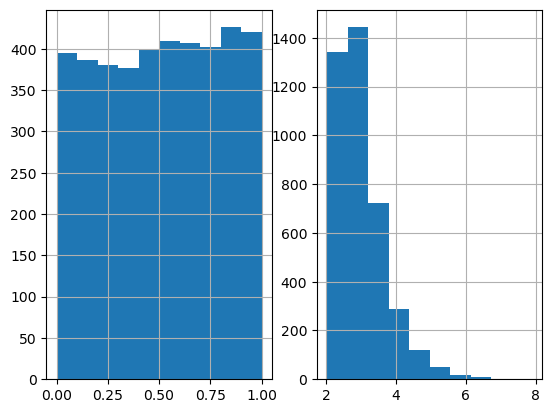

In [18]:
_, axs = plt.subplots(1, 2)
pd.Series(trace["omega0"]).hist(ax = axs[0])
pd.Series(trace["kappa0"]).hist(ax = axs[1])

In [19]:
with pm.Model() as model:
    omega0 = pm.Beta("omega0", 1, 1)
    kappa0_minus_two = pm.Gamma("kappa0_minus_two", 2, 2)
    kappa0 = pm.Deterministic("kappa0", kappa0_minus_two + 2)
    
    theta = pm.Beta("theta", omega0*(kappa0 - 2) + 1, (1 - omega0)*(kappa0 - 2) + 1, observed = vehicles_data.vehicle_score)
    trace = pm.sample()

/tmp/ipykernel_8125/282167036.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa0_minus_two, omega0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


/tmp/ipykernel_8125/4255668653.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/home/alebu/anaconda3/envs/experiments/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<Axes: title={'center': 'omega0'}>,
        <Axes: title={'center': 'omega0'}>],
       [<Axes: title={'center': 'kappa0_minus_two'}>,
        <Axes: title={'center': 'kappa0_minus_two'}>],
       [<Axes: title={'center': 'kappa0'}>,
        <Axes: title={'center': 'kappa0'}>]], dtype=object)

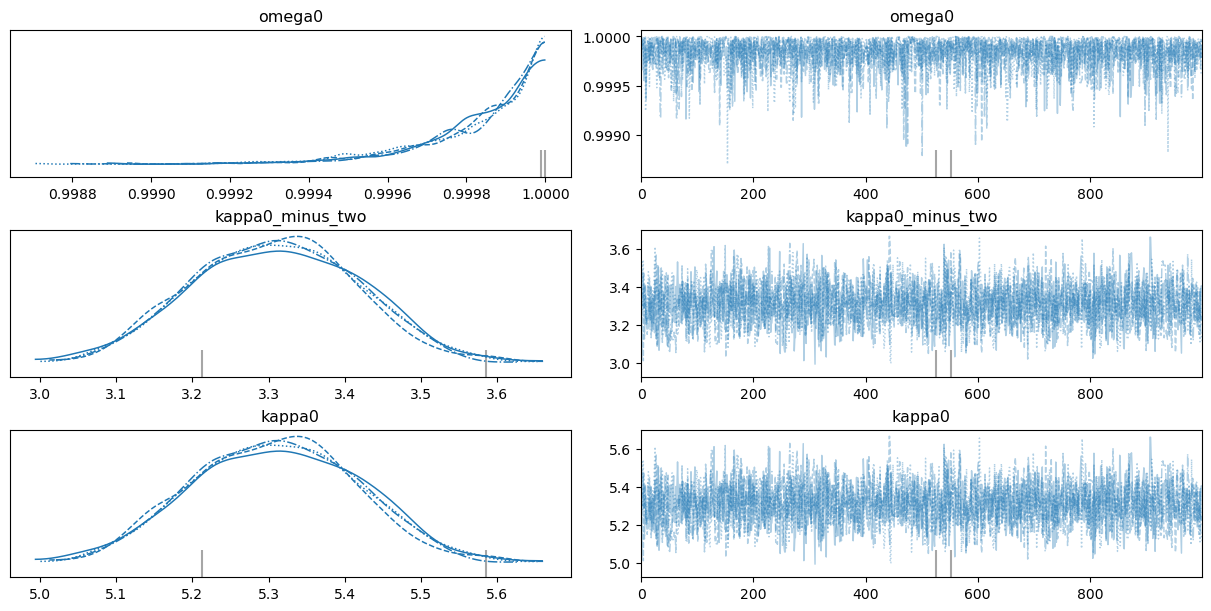

In [20]:
pm.traceplot(trace)

In [23]:
with pm.Model() as model:
    omega0 = pm.Beta("omega0", 1, 1)
    kappa0_minus_two = pm.Gamma("kappa0_minus_two", 2, 2)
    kappa0 = pm.Deterministic("kappa0", kappa0_minus_two + 2)

    omega = pm.Beta("omega", omega0*(kappa0 - 2) + 1, (1 - omega0)*(kappa0 - 2) + 1, shape=n_fleets)
    kappa_minus_two = pm.Gamma("kappa_minus_two", 2, 2, shape=n_fleets)
    kappa = pm.Deterministic("kappa", kappa_minus_two + 2)
    
    theta = pm.Beta("theta", omega[vehicles_data.fleet_id]*(kappa[vehicles_data.fleet_id] - 2) + 1, (1 - omega[vehicles_data.fleet_id])*(kappa[vehicles_data.fleet_id] - 2) + 1, observed = vehicles_data.vehicle_score)
    trace = pm.sample(10000)

/tmp/ipykernel_8125/3178143421.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [kappa_minus_two, omega, kappa0_minus_two, omega0]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 62 seconds.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


/tmp/ipykernel_8125/4255668653.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/home/alebu/anaconda3/envs/experiments/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<Axes: title={'center': 'omega0'}>,
        <Axes: title={'center': 'omega0'}>],
       [<Axes: title={'center': 'kappa0_minus_two'}>,
        <Axes: title={'center': 'kappa0_minus_two'}>],
       [<Axes: title={'center': 'kappa0'}>,
        <Axes: title={'center': 'kappa0'}>],
       [<Axes: title={'center': 'omega'}>,
        <Axes: title={'center': 'omega'}>],
       [<Axes: title={'center': 'kappa_minus_two'}>,
        <Axes: title={'center': 'kappa_minus_two'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>]], dtype=object)

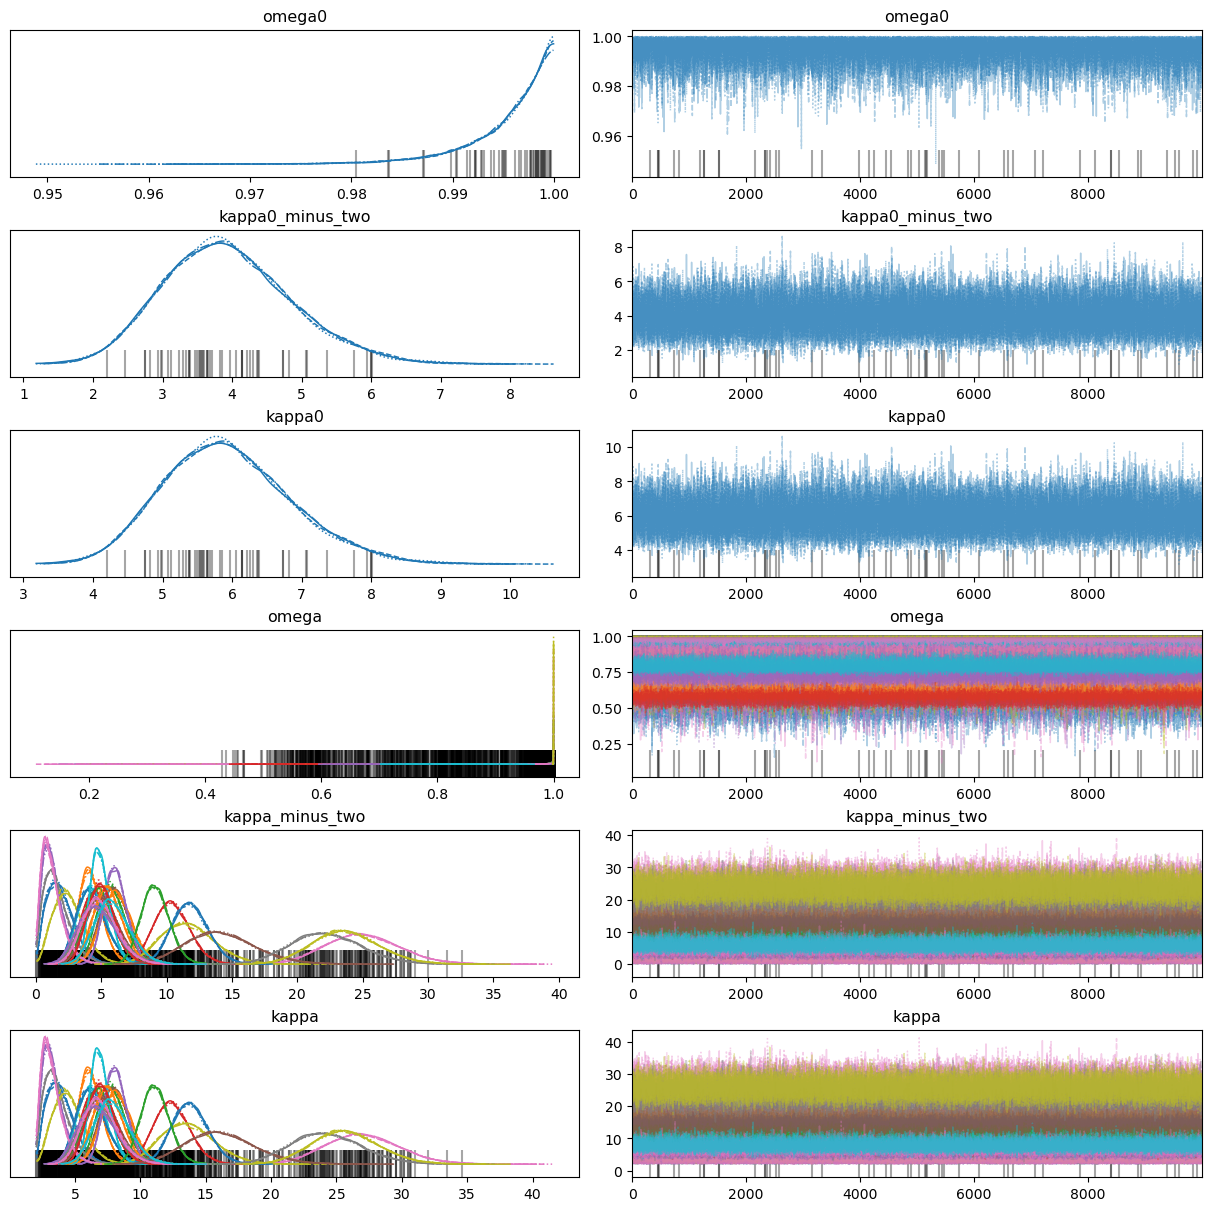

In [25]:
pm.traceplot(trace)

In [33]:
inference["omega"] = trace["omega"].mean(axis = 0)

In [34]:
inference

,fleet_id,vehicle_score,n_vehicles_in_fleet,fleet_true_risk,omega
0,0,0.517449,21,0.519144,0.624259
1,1,0.856283,36,0.868704,0.978761
2,2,0.890510,46,0.886922,0.985581
3,3,0.806005,60,0.815206,0.915838
4,4,0.744982,4,0.813580,0.867067
5,5,0.758960,97,0.774845,0.835156
6,6,0.985451,85,0.982724,0.999894
7,7,0.960592,4,0.960276,0.960829
8,8,0.575976,24,0.577922,0.674157
9,9,0.556727,56,0.579910,0.590250


In [19]:
vehicles_data.fleet_id

,fleet_id,fleet_vehicle_id,vehicle_score
0,0,00,0.396969
1,0,01,0.603517
2,0,02,0.698922
3,0,03,0.574720
4,0,04,0.424530
...,...,...,...
57,29,2957,0.603165
58,29,2958,0.530216
59,29,2959,0.613728
60,29,2960,0.598885


<Axes: >

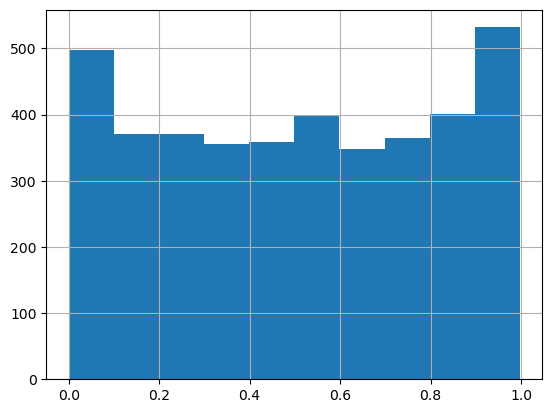

In [13]:
pd.Series(trace["theta"]).hist()

In [33]:
with pm.Model() as model:
    omega0 = pm.Beta("omega0", 1, 1)
    kappa0_minus_two = pm.Gamma("kappa0_minus_two", 0.01, 0.01)
    kappa0 = pm.Deterministic("kappa0", kappa0_minus_two + 2)
    
    omega = pm.Beta("omega", omega0*(kappa0 - 2) + 1, (1 - omega0)*(kappa0 - 2) + 1, shape=n_fleets)
    kappa_minus_two = pm.Gamma("kappa_minus_two", 0.01, 0.01, shape=n_fleets)
    kappa = pm.Deterministic("kappa", kappa_minus_two + 2)
    
    theta = pm.Beta("theta", omega[vehicles_data.fleet_id]*(kappa[vehicles_data.fleet_id] - 2) + 1, (1 - omega[vehicles_data.fleet_id])*(kappa[vehicles_data.fleet_id] - 2) + 1, observed = vehicles_data.vehicle_score)
    trace = pm.sample()

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'omega0_logodds__': array(0.), 'kappa0_minus_two_log__': array(0.), 'omega_logodds__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'kappa_minus_two_log__': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])}

Initial evaluation results:
omega0_logodds__          -1.39
kappa0_minus_two_log__    -4.66
omega_logodds__          -22.89
kappa_minus_two_log__    -93.11
theta                      -inf
Name: Log-probability of test_point, dtype: float64

In [31]:
trace["kappa"]

array([[2.        , 2.        , 2.41609284, ..., 2.00096449, 2.        ,
        2.        ],
       [2.        , 2.        , 2.00000008, ..., 2.09481287, 2.        ,
        2.        ],
       [2.        , 2.        , 2.        , ..., 2.10508832, 2.        ,
        2.        ],
       ...,
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ],
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ],
       [2.        , 2.        , 2.        , ..., 2.        , 2.        ,
        2.        ]])

In [30]:
pd.Series(trace["kappa"]).hist()

ValueError: Data must be 1-dimensional

/tmp/ipykernel_449216/4255668653.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)
/home/alebu/anaconda3/envs/experiments/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<Axes: title={'center': 'omega0'}>,
        <Axes: title={'center': 'omega0'}>],
       [<Axes: title={'center': 'kappa0_minus_two'}>,
        <Axes: title={'center': 'kappa0_minus_two'}>],
       [<Axes: title={'center': 'kappa0'}>,
        <Axes: title={'center': 'kappa0'}>],
       [<Axes: title={'center': 'omega'}>,
        <Axes: title={'center': 'omega'}>],
       [<Axes: title={'center': 'kappa_minus_two'}>,
        <Axes: title={'center': 'kappa_minus_two'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

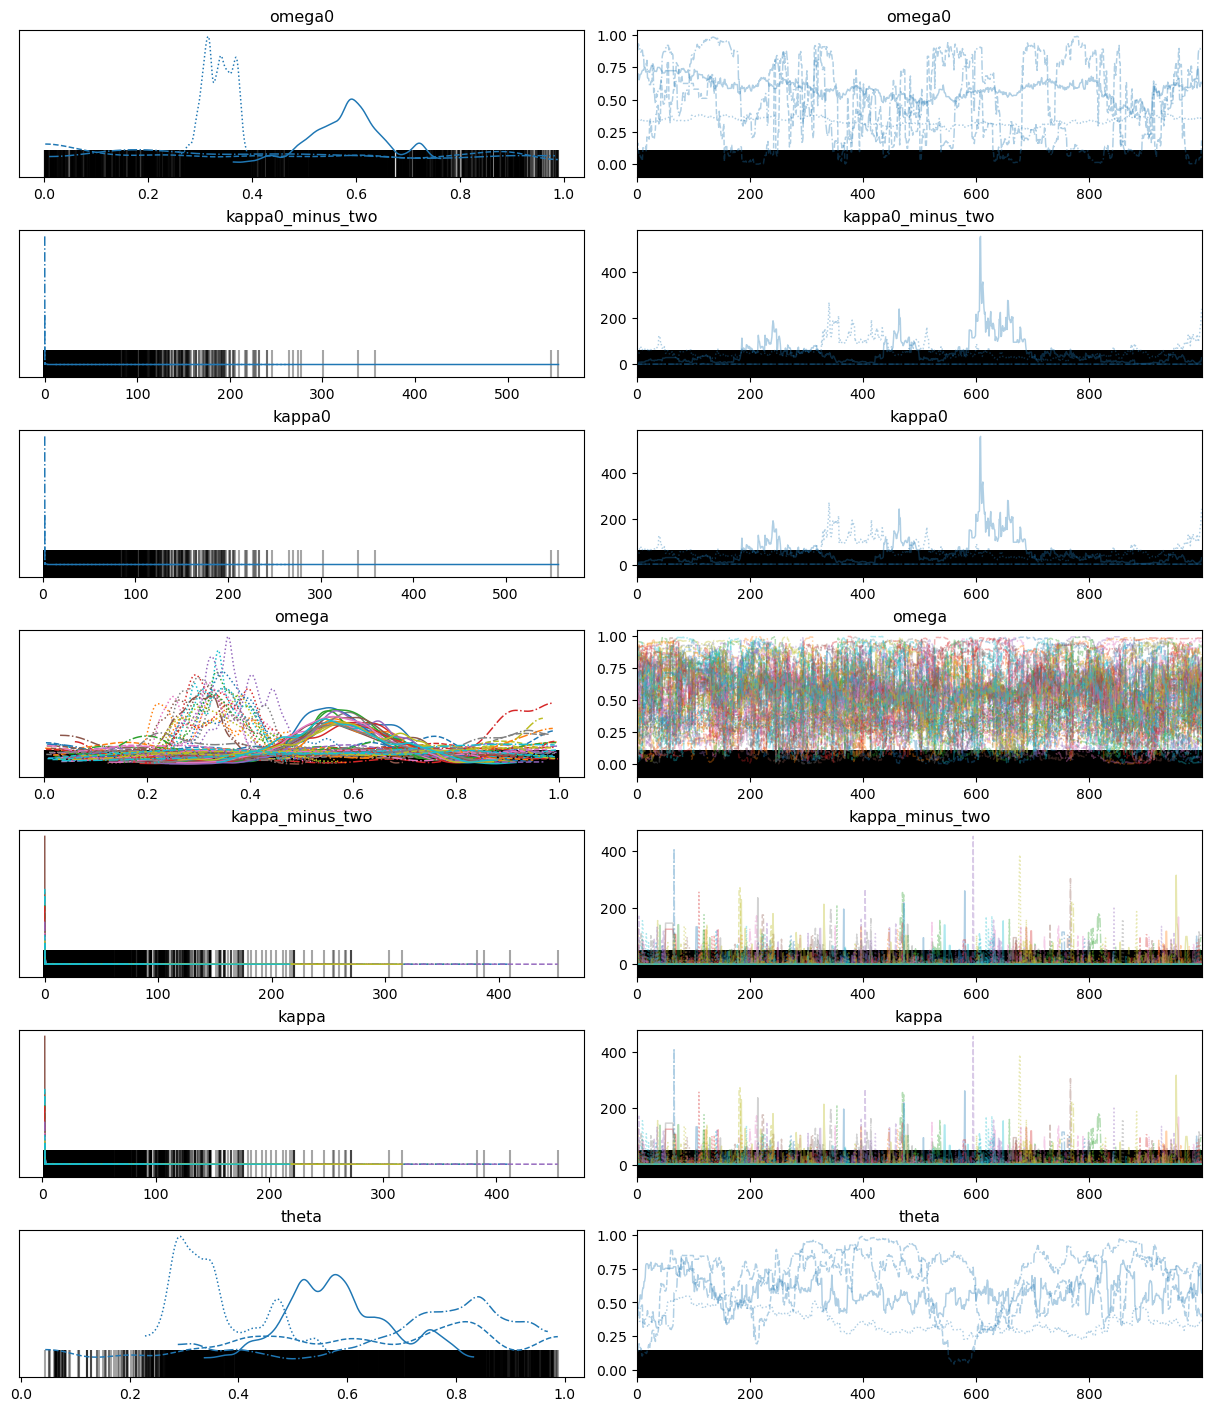

In [12]:
pm.traceplot(trace)

In [ ]:
with pm.Model() as model:
    # omega0 = pm.Beta("omega0", 1, 1)
    # kappa0_minus_two = pm.Gamma("kappa0_minus_two", 0.01, 0.01)
    # kappa0 = pm.Deterministic("kappa0", kappa0_minus_two + 2)
    
    # omega = pm.Beta("omega", omega0*(kappa0 - 2) + 1, (1 - omega0)*(kappa0 - 2) + 1, shape=n_pos)
    # kappa_minus_two = pm.Gamma("kappa_minus_two", 0.01, 0.01, shape=n_pos)
    # kappa = pm.Deterministic("kappa", kappa_minus_two + 2)
    
    theta = pm.Beta("theta", 1, 1)
    trace = pm.sample()